# PHYS3070 2025: Non-linear inverse problem: Earthquake location

<a href="https://colab.research.google.com/github/tsonpham/InvProb/blob/master/Lec2_EqLoc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Prepared by Thanh-Son Pham (thanhson.pham@anu.edu.au), September 2025.

---
## What we do in this notebook:
- Earthquake location as a non-linear inverse problem.
- Iterative linearized method.
- Bayesian inference and output analysis. 
- Earthquake source uncertainty.

The next cell installs some library packages will be used in this notebook. It must be run on Google Colab to set up the working environment in the remote server (nothing will be installed on your computer).

In [11]:
# set up colab environment - uncomment the next line if running in colab

# !pip install emcee arviz corner

In [12]:
#@title Run to activate retina display

%config InlineBackend.figure_format = "retina"
from matplotlib import rcParams

rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 10

---
## Problem statement

Earthquake location is a classic problem in seismology. Here we consider a synthetic problem to locate a seismic source in a homogenous, acoustic media. The setup includes:
- A seismic source is located at 10 km depth, triggered at the origin time, $t=0$.
- 10 receivers randomly located on the free surface $(x_i, y_i, 0)$, where $i = 1, ..., 10$.
- Energy from the source propagates at a homogenous speed $v= 5 km/s$ in the media.

Given ${d_i, i=1, ..., 10}$ being the travel arrival times observed at the receivers. What are the location and time of the source?

Source: Section 7.2, Stein & Wysession, *An introduction to seismology, earthquakes, and earth structure*, 2003.

In [13]:
import numpy as np

# true earthquake location
m_true = np.array([0, 0, 10, 0])
v = 5

# station locations
np.random.seed(2)
nr = 10
rcvs = np.zeros((nr, 3)) # receiver coordinates
rcvs[:, :2] = np.random.uniform(-300, 300, (nr, 2)) # randomised x, y, z=0

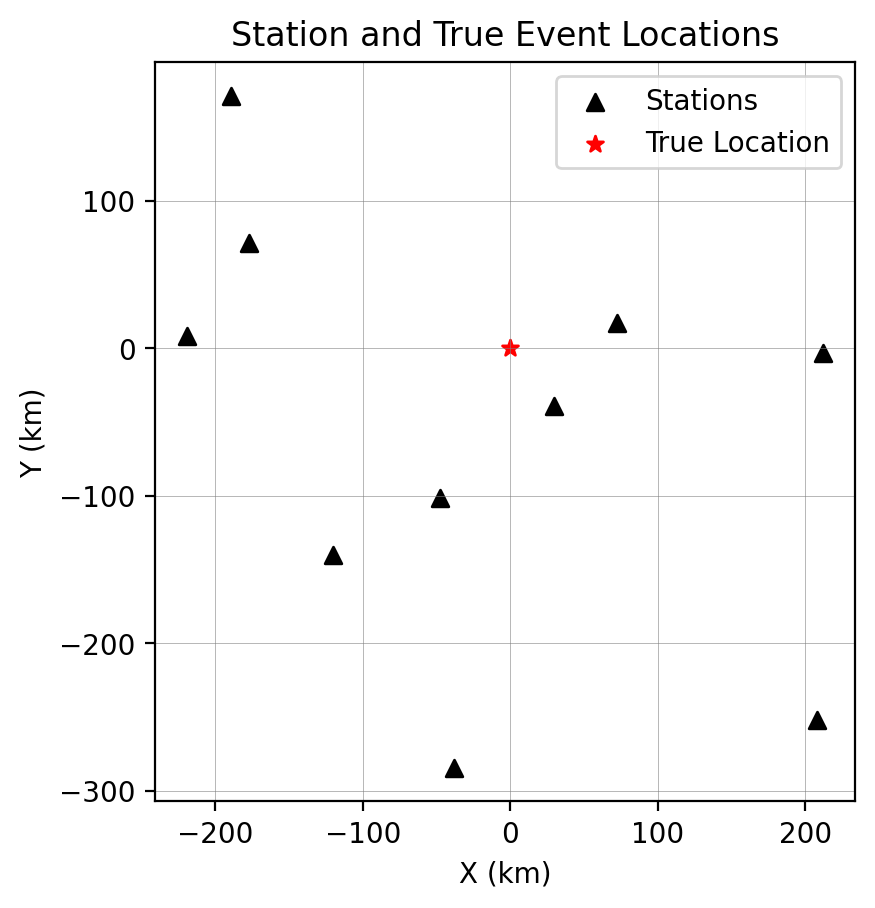

In [14]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.scatter(rcvs[:, 0], rcvs[:, 1], marker='^', color='k', label='Stations')
ax.scatter(m_true[0], m_true[1], marker='*', color='r', label='True Location')
ax.set(xlabel='X (km)', ylabel='Y (km)', title='Station and True Event Locations')
ax.set(aspect='equal', adjustable='box')
ax.grid(lw=.2, color='gray')
plt.legend()
plt.show()

--- 
## Non-linear forward problem

In a homogenous media, seismic wave propagate along a straight rays, just the forward problem derterming the arrival times to each station is defined as,
$$
\hat{d}_i = \frac{\sqrt{(x_i - x_s)^2 + (y_i - y_s)^2 + z_s^2}}{v} + t,
$$
where $(x_s, y_s, z_s)$ are coordinates of the seismic sources. Note that the forward problem can not be represented directly in the linear form of the unknown parameters.
$$
d_i = \hat{d}_i + \mathcal{N}(0, \sigma).
$$
$\sigma$ is the standard deviation of the travel time measurement errors.

In [15]:
def forward_prob(m): return np.linalg.norm(rcvs - m[0:3], axis=1) / v + m[3]

sigma = 0.1
data = forward_prob(m_true) + np.random.normal(0, sigma, size=nr) # add noise

---
## Linearized iteration method

The non-linear inverse problem is written in the closed form as,
$$
\mathbf{d} = g(\mathbf{m}).
$$
where
$\mathbf{m} = [x, y, z, t]^T$ is a colum vector of model parameters representing the coordinate in 3D and origin time of the source. Note that the subscript $s$ is dropped from the above expression for simplicity. $\mathbf{d}$ is a column vector of observed arrival times.

The *mean value theorem* uses only the first derivative term to relate a small perturbation $\Delta \mathbf{m}$ and the corresponding perturbation in the data,
$$
g(\mathbf{m} + \Delta \mathbf{m}) \approx g(\mathbf{m}) + \nabla g(\mathbf{m})^T \Delta \mathbf{m}.
$$
Note that: $\Delta \mathbf{d} := g(\mathbf{m} + \Delta \mathbf{m}) - g(\mathbf{m})$ and the Jacobian matrix $\mathbf{G}=\{g_{ij}\; i=1\ldots m, 1\ldots n\}$, where
$$
g_{ij} = \frac{\partial d_i}{\partial m_j}.
$$

The above approximation can be written in the matrix multiplication form,
$$
\Delta \mathbf{d} = \mathbf{G} \Delta \mathbf{m}.
$$

The above equation suggests that to bring the current predicted data vector toward the observation, one needs to leap in the model paramter space a step, defined as,
$$
\Delta \mathbf{m} = (\mathbf{G}^T \mathbf{G})^{-1} \mathbf{G}^T \Delta \mathbf{d}.
$$

This allows to iteratively progress to the optimal solution,
$$
d_i = T(\mathbf{x}, \mathbf{x}_i) + t = \frac{1}{v}[(x - x_i)^2 + (y - y_i)^2 + z^2]^{1/2} + t.
$$

In the earthquake location problem, the element of the Jacobian matrix is 
$$
g_{i1} = \frac{\partial d_i}{\partial m_1} = \frac{\partial d_i}{\partial x} = \frac{T(\mathbf{x}, \mathbf{x}_i)}{\partial x} = \frac{(x-x_i)}{v}[(x - x_i)^2 + (y - y_i)^2 + z^2]^{-1/2},
$$
$$
g_{i2} = \frac{\partial d_i}{\partial m_2} = \frac{\partial d_i}{\partial y} = \frac{T(\mathbf{x}, \mathbf{x}_i)}{\partial x} = \frac{(y-y_i)}{v}[(x - x_i)^2 + (y - y_i)^2 + z^2]^{-1/2},
$$
$$
g_{i3} = \frac{\partial d_i}{\partial m_3} = \frac{\partial d_i}{\partial z} = \frac{T(\mathbf{x}, \mathbf{x}_i)}{\partial x} = \frac{z}{v}[(x - x_i)^2 + (y - y_i)^2 + z^2]^{-1/2},
$$
$$
g_{i4} = \frac{\partial d_i}{\partial m_2} = \frac{\partial d_i}{\partial t} = 1.
$$

In [16]:
def jacobian_mat(m):
    dist = np.linalg.norm(rcvs - m[0:3], axis=1)
    G = np.ones((nr, 4))
    G[:, :3] = np.einsum('ij,i->ij', m[0:3]-rcvs, 1 / (v * dist))
    return G

m0 = np.array([3, 4, 20, 2])
print ('m0:', m0)

G0 = jacobian_mat(m0)
delta_d = data - forward_prob(m0)
delta_m = np.linalg.pinv(G0) @ delta_d
m1 = m0 + delta_m
print ('m1:', m1)

G1 = jacobian_mat(m1)
delta_d = data - forward_prob(m1)
delta_m = np.linalg.pinv(G1) @ delta_d
m2 = m1 + delta_m
print ('m2:', m2)

G2 = jacobian_mat(m2)
delta_d = data - forward_prob(m2)
delta_m = np.linalg.pinv(G2) @ delta_d
m3 = m2 + delta_m
print ('m3:', m3)

print ('--------------')
print ('mt:', m_true)

m0: [ 3  4 20  2]
m1: [ 0.17080348 -0.09526355 13.63544478 -0.07129062]
m2: [ 0.20345501 -0.03453947 11.94184539 -0.078673  ]
m3: [ 0.20353343 -0.03433373 11.83406707 -0.07884537]
--------------
mt: [ 0  0 10  0]


As noted, the improvement between solutions from iterations 2 and 3 become very small, which indicates that the iteration can be stopped and $\mathbf{m}_3$ can be used as the optimal solution.

The data covariance matrix of the estimated source location is given by 
$$
Cov(\mathbf{m}) = \sigma (\mathbf{G}^T\mathbf{G})^{-1}
$$
where $\mathbf{G}^T$ is evaluated at the converged solution, .e.g., $\mathbf{m}_3$ in this example.

In [17]:
cov_m = sigma**2 * np.linalg.inv(G2.T @ G2)
std_m = np.sqrt(np.diag(cov_m))
print ('std_m:', std_m)

std_m: [0.23377161 0.27868881 2.85128128 0.06085029]


Note that the converged solution with 95\% convidence interval ($2\sigma$) is
$$
\begin{align}
x &= 0.20 \pm 0.47 \text{ (km)}\\
y &= 0.07 \pm 0.55 \text{ (km)}\\
z &= 11.83 \pm 5.70 \text{ (km)}\\
t &= -0.08 \pm 0.12 \text{ (s)}.
\end{align}
$$

Source depth is the hardest parameter to control. One needs to have receiver above the source to contrain it properly.

---
## Bayesian inference

### Prior probability

Bayesian sampling requires a prior probability density function. A common problem with polynomial coefficients as model parameters is that it is not at all obvious what a prior should be. Here we choose a uniform prior with specified bounds
$$
\begin{align*}
p({\mathbf m}) &= \frac{1}{V},\quad  l_i \le m_i \le u_i, \quad (i=1,\dots,M)\\
         &= 0, \quad {\rm otherwise},
\end{align*}
$$
where $l_i$ and $u_i$ are lower and upper bounds on the $i$th model coefficient.

It is convient to work with log probability in Bayesian sampling and assume $V=1$ as it's a constant,
$$
\begin{align*}
\log p({\mathbf m}) &= 0,\quad  l_i \le m_i \le u_i, \quad (i=1,\dots,M)\\
         &= -\infty, \quad {\rm otherwise},
\end{align*}
$$

Here use the uniform distribution with ${\mathbf l}^T = (-10.,-10.,0.,-10.)$, and ${\mathbf u}^T = (10.,10.,20.,10.)$.

In [18]:
nparams = len(m_true)
m_lower_bound = np.array([-10, -10, 0, -10])  # lower bound for uniform prior
m_upper_bound = np.array([10, 10, 20, 10])    # upper bound for uniform prior

def log_prior(model):    # uniform distribution
    for i in range(len(m_lower_bound)):
        if model[i] < m_lower_bound[i] or model[i] > m_upper_bound[i]: return -np.inf
    return 0.0 # model lies within bounds -> return log(1)

### Likelihood

Since data errors follow a Gaussian in this example, we can define a likelihood function, $p({\mathbf d}_{obs}| {\mathbf m})$.

$$
p({\mathbf d}_{obs} | {\mathbf m}) = \dfrac{1}{\sqrt{(2\pi)^N\det(C_D)}} \exp \left\{- \frac{1}{2} ({\mathbf d}_{obs}-{\mathbf d}_{pred}({\mathbf m}))^T C_D^{-1} ({\mathbf d}_{obs}-{\mathbf d}_{pred}({\mathbf m})) \right\}
$$

where ${\mathbf d}_{obs}$ represents the observed y values and ${\mathbf d}_{pred}({\mathbf m})$ are those predicted by the polynomial model $({\mathbf m})$. The Likelihood is defined as the probability of observing the data actually observed, given a model. In practice we usually only need to evaluate the log of the Likelihood, $\log p({\mathbf d}_{obs} | {\mathbf m})$.

To do so, we require the inverse data covariance matrix describing the statistics of the noise in the data, $C_D^{-1}$. For this problem the data errors are independent with identical standard deviation in noise for each datum. Hence $C_D^{-1} = \frac{1}{\sigma^2}I$ and $\det(C_D) = \sigma^{2N}$ and the likelihood function becomes
$$
p({\mathbf d}_{obs} | {\mathbf m}) = (2\pi \sigma^2)^{-\dfrac{N}{2}} \exp \left\{- \frac{1}{2} \sum_{i=1}^N\left(\dfrac{d_{obs}^i - d_{pred}^i}{\sigma}\right)^2\right\}.
$$

For convenience, the log probability is often used to simplify the calculation and avoid floating over/underflow errors,
$$
\log p({\mathbf d}_{obs} | {\mathbf m}) = - \frac{1}{2}\left(N \log (2\pi\sigma^2) + \sum_{i=1}^N\left(\dfrac{d_{obs}^i - d_{pred}^i}{\sigma}\right)^2\right).
$$

When the data noise amplitude, $\sigma$ is assumed or estimated a priori, the likelihood function can be simplified even further,
$$
\log p({\mathbf d}_{obs} | {\mathbf m}) = - \frac{1}{2}\sum_{i=1}^N\left(\dfrac{d_{obs}^i - d_{pred}^i}{\sigma}\right)^2.
$$

Note that the data vector $\mathbf y$ is ${\mathbf d}_{obs}$ in this context.

In [19]:
def log_likelihood(model):
    pred = forward_prob(model)
    residual = data - pred
    return -0.5 * np.sum(residual**2 / sigma**2)

### Bayesian sampling

In this aproach we sample a probability distribution rather than find a single best fit solution. Bayes' theorem tells us the the posterior distribution is proportional to the likelihood and the prior.

$$p(\mathbf{m}|\mathbf{d}_{obs}) = K p(\mathbf{d}_{obs}|\mathbf{m})p(\mathbf{m})$$

where $K = \dfrac{1}{p(\mathbf{d}_{obs})}$ is some constant. Under the assumptions specified $p(\mathbf{m}|\mathbf{d}_{obs})$ gives a probability density of models that are supported by the data. We seek to draw random samples from $p(\mathbf{m}|\mathbf{d}_{obs})$ over model space and then to make inferences from the resulting ensemble of model parameters.

When dropping the constant, the log posterior probability is written simply as,
$$
\log p(\mathbf{m}|\mathbf{d}_{obs}) = \log p(\mathbf{d}_{obs}|\mathbf{m}) + \log p(\mathbf{m}),
$$
or explicitly,
$$
\begin{align*}
\log p({\mathbf m} | {\mathbf d}_{obs}) &= - \frac{1}{2}\sum_{i=1}^N\left(\dfrac{d_{obs}^i - d_{pred}^i}{\sigma}\right)^2,\quad  l_i \le m_i \le u_i, \quad (i=1,\dots,M)\\
         &= -\infty, \quad {\rm otherwise},
\end{align*}
$$

A proposed sample $\mathbf m$ will never be accepted if drawn outside the parameter boundaries and might accepted with some randomness.

In this example we make use of *The Affine Invariant Markov chain Monte Carlo (MCMC) Ensemble sampler*
[Goodman and Weare 2010](https://msp.org/camcos/2010/5-1/p04.xhtml) to sample the
posterior distribution of the model. (See more details about [emcee](https://emcee.readthedocs.io/en/stable/)).

In [20]:
def log_probability(model):
    return log_prior(model) + log_likelihood(model)

### Run McMC chain to sample the posterior probability
Now we define some hyperparameters (e.g. the number of walkers and steps), and initialise the random starting positions of walkers. We start all walkers in a small ball about a chosen point $(0, 0, 0, 0)$.

The ensemble sampler with 32 walkers is run for 10,000 steps, meaning there are 320,000 samples of the model space will be drawn from by the sampler.

In [21]:
nwalkers = 32
ndim = nparams
nsteps = 10000
walkers_start = m_lower_bound + (m_upper_bound - m_lower_bound) * np.random.rand(nwalkers, ndim)

import emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability)
output = sampler.run_mcmc(walkers_start, 10000, progress=True)

100%|██████████| 10000/10000 [00:11<00:00, 849.11it/s]


## Analysis of McMC output

First, we want to inspect whether the sampled chains converged to stable solutions.

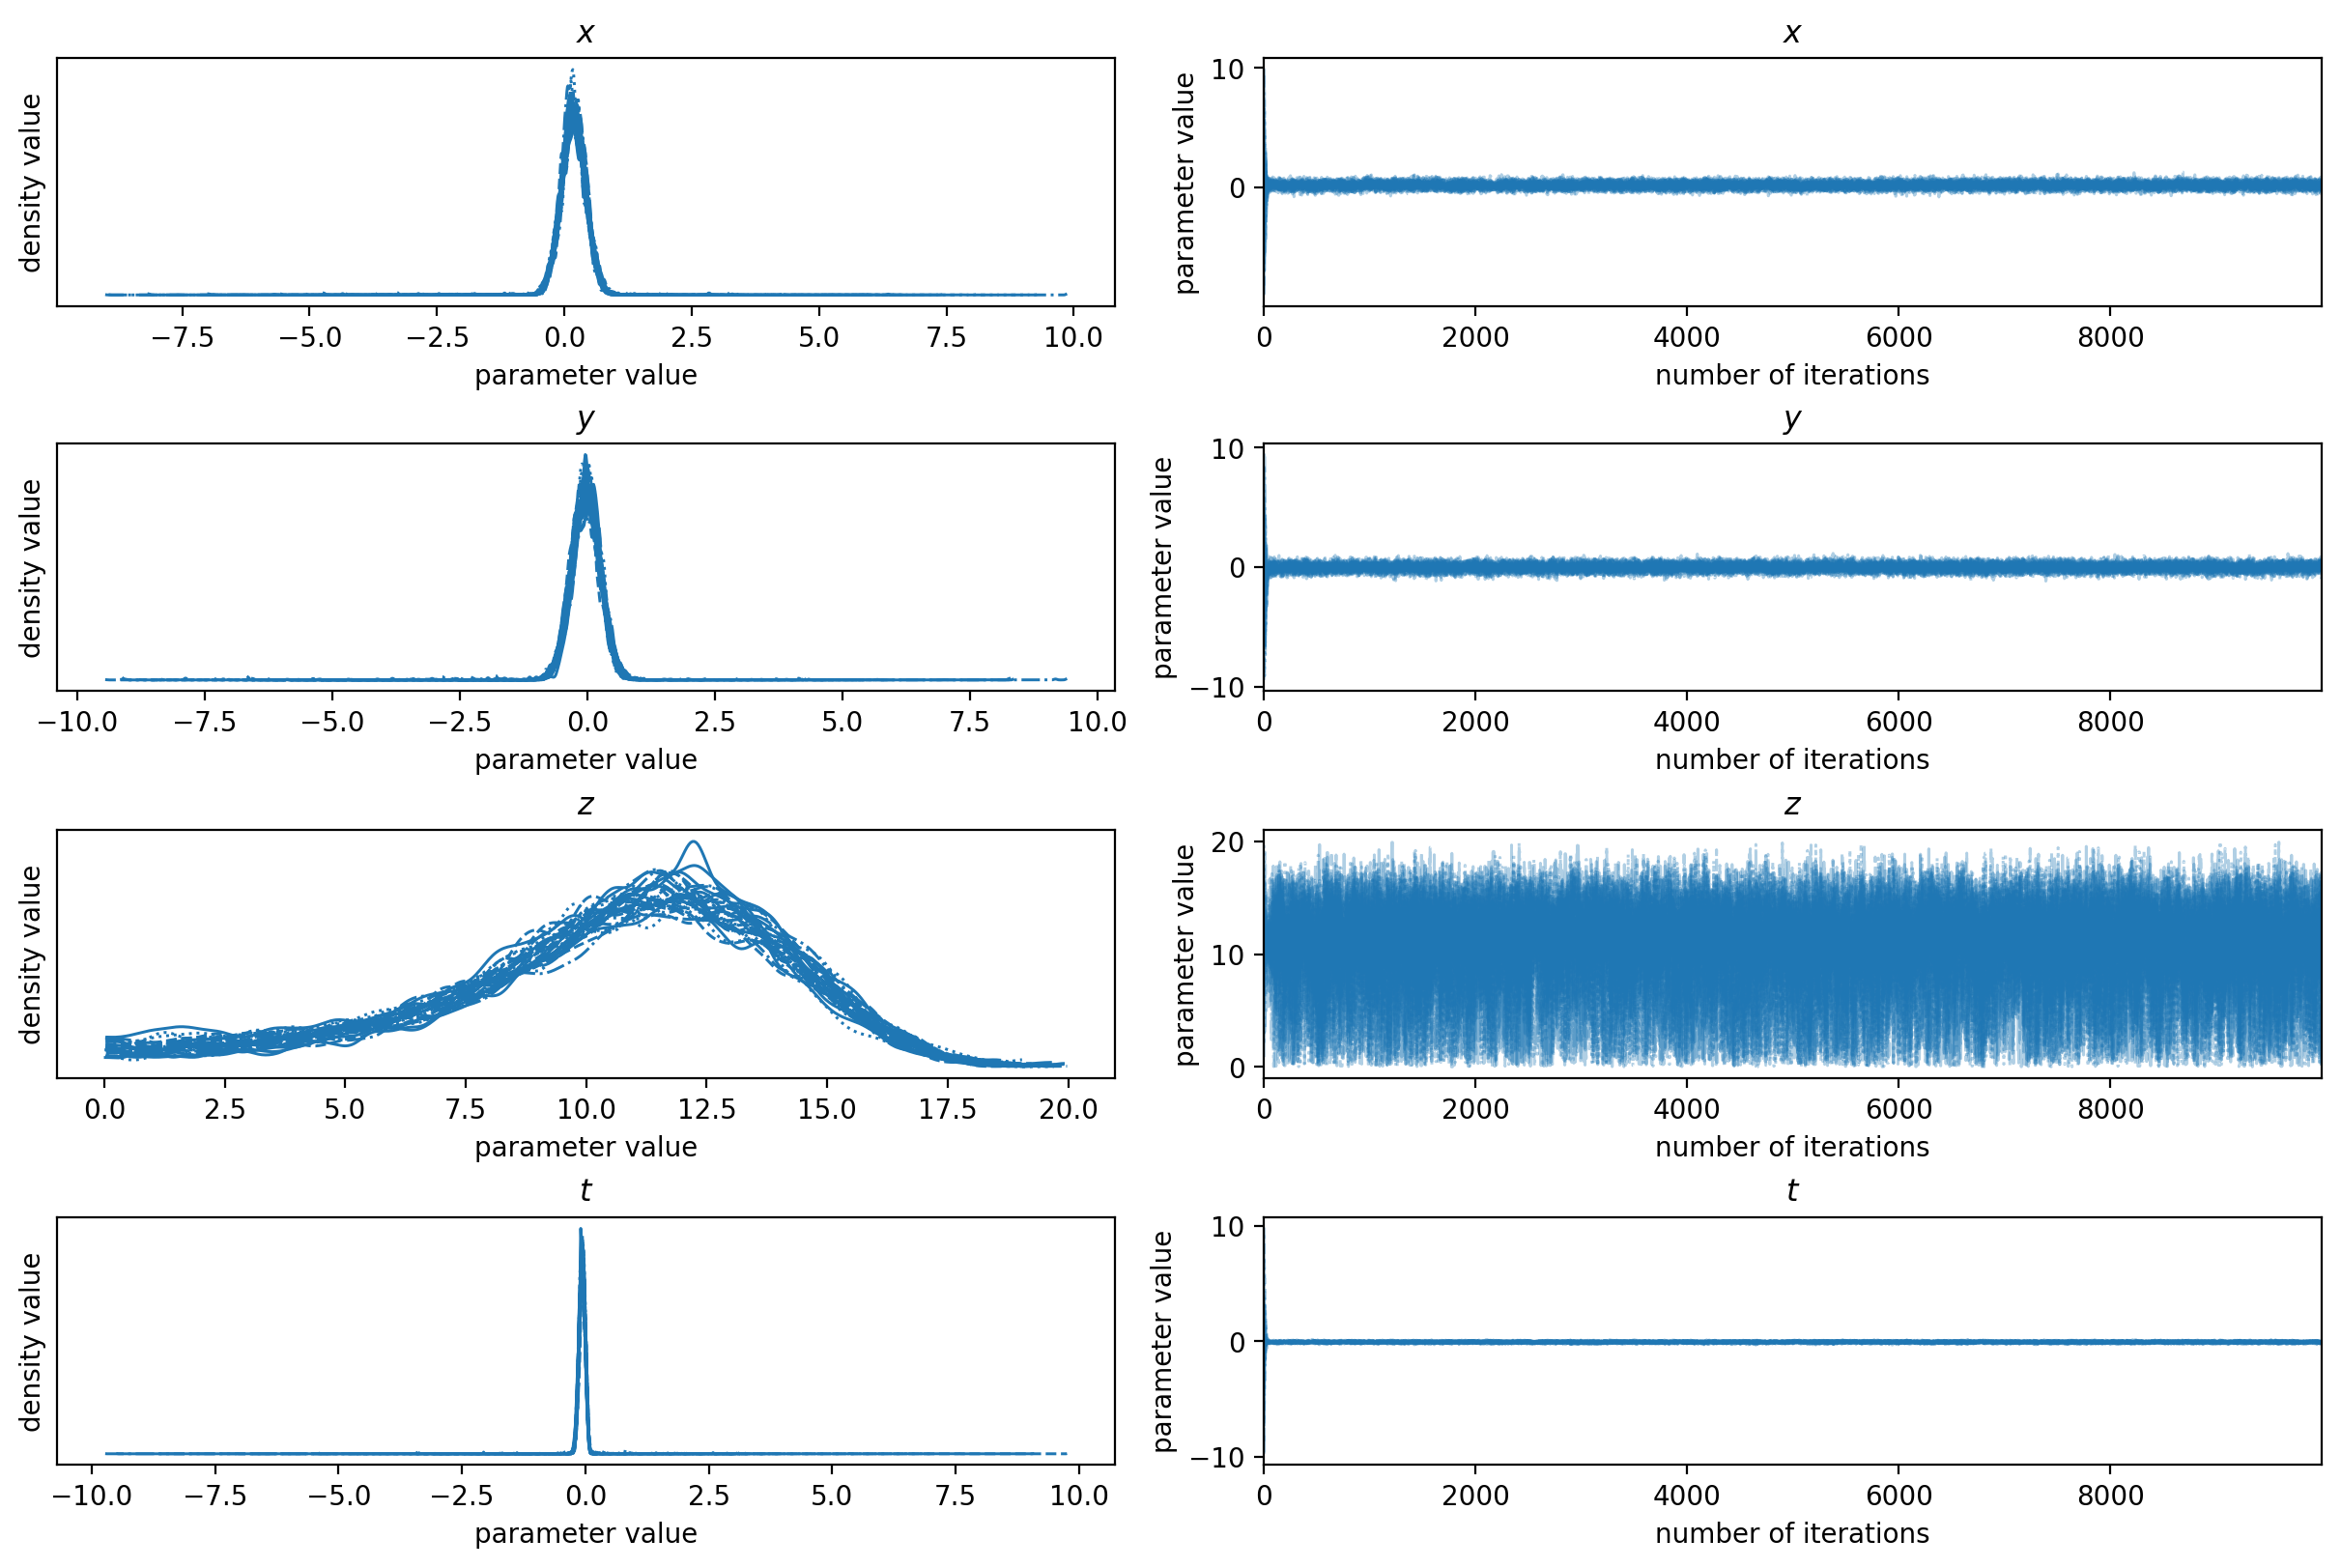

In [22]:
import arviz as az
labels = ["$x$", "$y$", "$z$","$t$"]
idata = az.from_emcee(sampler, var_names=labels)
idata.get("posterior")

# a standard `trace` plot
axes = az.plot_trace(idata, backend_kwargs={"constrained_layout":True})
# add legends
for i, axes_pair in enumerate(axes):
    ax1 = axes_pair[0]
    ax2 = axes_pair[1]
    # ax1.axvline(true_model[i], linestyle='dotted', color='red')
    ax1.set_xlabel("parameter value")
    ax1.set_ylabel("density value")
    ax2.set_xlabel("number of iterations")
    ax2.set_ylabel("parameter value")

The model ensemble should sample the posterior relatively independently. Thus, it's common practice in Bayesian analysis to discard the first part of the sampling chains (i.e., the burn-in, sometimes called warming-up stage) and thin the chain (i.e., take one every $K$ sample).

This come the next questions, how many initial model to discard and much to thin out the chain?

The autocorrelation time give give rough answers to the questions. Autocorrelation time $\tau$ is the time interval between sampling steps where two samples significantly related (read more [here](https://emcee.readthedocs.io/en/stable/user/autocorr/)). As a rule of thumb, we discard $5\tau$ and thin the chains at every $\tau/2$ samples.

In [23]:
tau = sampler.get_autocorr_time()
print(f"autocorrelation time: {tau}")

discard = int(5 * np.max(tau))  # discard the first 5*tau samples
thin = int(0.5 * np.min(tau))    # thin the chain at every tau/2 samples
flat_samples = sampler.get_chain(discard=discard, thin=thin, flat=True)

autocorrelation time: [43.66177059 43.9063349  53.82244698 33.52725146]


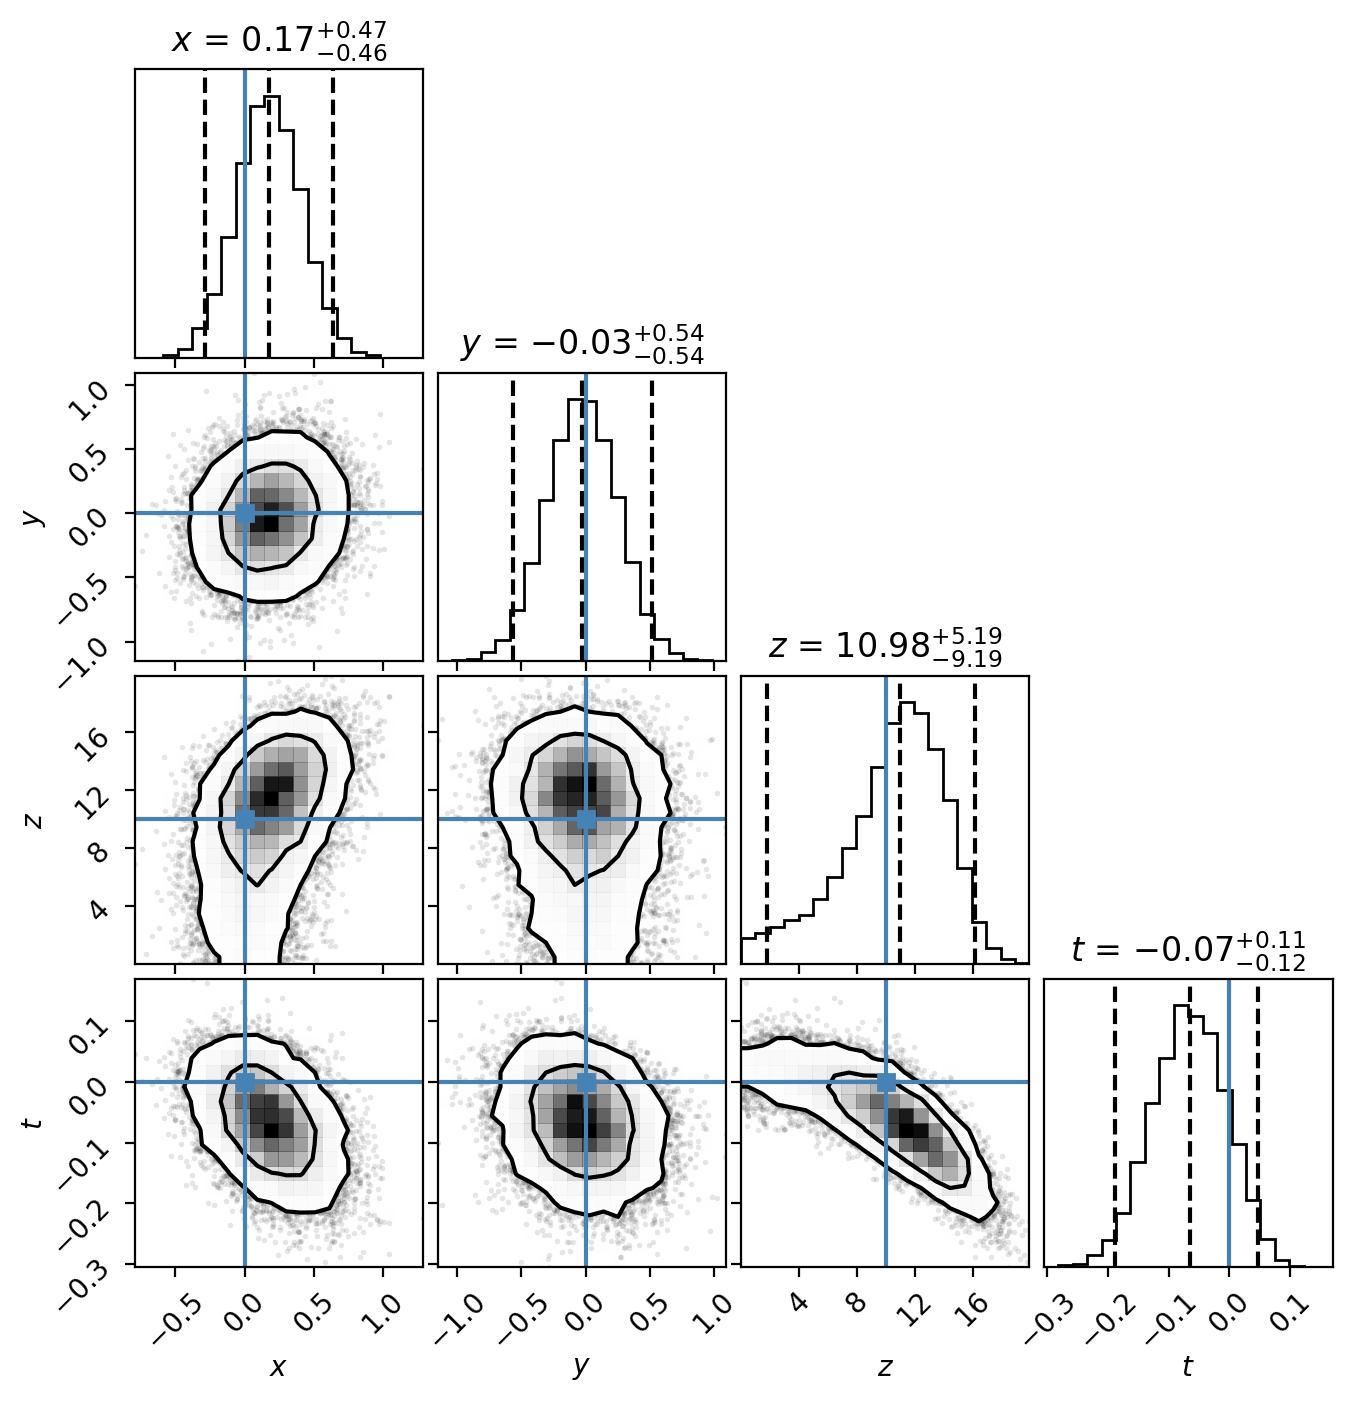

In [24]:
import corner
import matplotlib.pyplot as plt
fig = corner.corner(flat_samples, labels=labels, truths=m_true,
                     quantiles=[0.025, 0.5, 0.975], show_titles=True,
                     title_kwargs={"fontsize": 12},
                     levels=(0.68, 0.95), alpha=0.1)
fig.set_size_inches(7, 7)
plt.show()

The errors bars here are given for the *credible intervals*, which is nuancely different from the *confidence intervals* used so far.

The depth is still subjected to the largest error bar.